In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
# from einops import rearrange, repeat
# import rosbags
import json
import open3d as o3d
import pandas as pd
import os
import copy
from utility import listFiles, quickVizNumpy
from scipy.spatial.transform import Rotation as R
from numpy import cos, sin, sqrt, arctan2, array
import torch.nn as nn
### fucking around
from pretrain import loadDataFromRegisteredSlam, cart2sph, preProcess
from train import getSamplesAndTarget, getSpacing
# from visualize import visualizeDir


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
name = r'building_with_rotation'
path = r'datasets/registered/' + name + r'.json'
data = loadDataFromRegisteredSlam(path)
# training_data = preProcess(data)
# np.random.shuffle(training_data)

<function matplotlib.pyplot.show(close=None, block=None)>

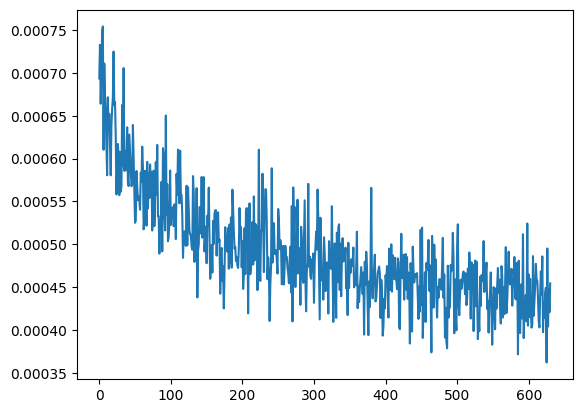

In [8]:
path = r'/home/ansonhon/anson/thesis/LiDAR_NeRF/local/losses_record/ver_euclidean_trial1_losses.npy'
losses = np.load(path)
plt.plot(losses[50:])
plt.show

In [7]:
losses[-1]

0.00045436603249982

In [7]:
temp = np.arange(-0.5,0.5,1/100)
grid_x, grid_y = np.meshgrid(temp,temp)

In [6]:
np.arange(-10,10,1000)

array([-10])

In [9]:
grid_x

array([[-0.5 , -0.49, -0.48, ...,  0.47,  0.48,  0.49],
       [-0.5 , -0.49, -0.48, ...,  0.47,  0.48,  0.49],
       [-0.5 , -0.49, -0.48, ...,  0.47,  0.48,  0.49],
       ...,
       [-0.5 , -0.49, -0.48, ...,  0.47,  0.48,  0.49],
       [-0.5 , -0.49, -0.48, ...,  0.47,  0.48,  0.49],
       [-0.5 , -0.49, -0.48, ...,  0.47,  0.48,  0.49]])

In [17]:
losses[-1]

0.00045465139555744827

In [4]:
torch.cuda.is_available()

False